In [1]:
import os
os.environ["KERAS_BACKEND"] = "jax"
import keras
from keras import layers
import numpy as np
import xarray as xr
import zarr
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import random
import jax
import tensorflow as tf

# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
jax.config.update('jax_enable_x64', True)
jax.random.PRNGKey(SEED)


# Set the working directory
os.chdir('/data/keeling/a/ad87/downscale')

2024-10-24 18:57:18.430923: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-24 18:57:18.448692: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-24 18:57:18.453944: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-24 18:57:19.892381: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


#### Data Handling: Load and Resample Data
We will load the CMIP6 data and the GMFD observational data. We’ll resample the GMFD data to the CMIP6 resolution (e.g., ~100 km) to use as the target during training.



In [2]:
# Load the CMIP6 raw data (predictor variables)
cmip6_data_path = '/data/cristi/a/cristi/downscaled_data/cmip6/raw/zarr/RO_CMIP6_raw/CNRM-ESM2-1/historical/r1i1p1f2/tas/tas_day_CNRM-ESM2-1_historical_r1i1p1f2_gr_1950_2014_rou.zarr'
cmip6_data = xr.open_zarr(cmip6_data_path)

# Load the GMFD reference observational data (target variable)
gmfd_data_path = '/data/keeling/a/cristi/a/downscaled_data/gmfd/ncs/ro'
gmfd_files = [f'{gmfd_data_path}/tas_daily_ro_{year}.nc' for year in range(1950, 2015)]
gmfd_data = xr.open_mfdataset(gmfd_files, combine='by_coords')

# Resample  CMIP6 to GMFD resolution (~25 km)
target_lat = gmfd_data.lat
target_lon = gmfd_data.lon
cmip6_high_res = cmip6_data.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})


# Normalize the data (standardization)
def normalize(data):
    mean = data.mean().compute().item()
    std = data.std().compute().item()
    return (data - mean) / std

cmip6_data_norm = normalize(cmip6_high_res['tas'])
gmfd_data_norm = normalize(gmfd_data['tas'])

# Convert data to NumPy arrays for use in Keras
cmip6_train = cmip6_data_norm.values
gmfd_train = gmfd_data_norm.values

In [5]:
cmip6_train.shape

(23741, 42, 97)

#### Build the CNN Model (Keras with JAX Backend)
Now let's define a simple CNN model using Keras with JAX backend. Our model will take the coarse-resolution CMIP6 data and predict the high-resolution GMFD data.



In [3]:
import keras
from keras import layers
import numpy as np
import jax
import jax.numpy as jnp

# Define the model architecture (as done earlier)
n = 32  # base filter count
input_shape = (cmip6_train.shape[1], cmip6_train.shape[2], 1)  # Assuming 1 channel (tas)

def build_network(input_shape):
    inputs = keras.Input(shape=input_shape)
    
    # Encoder with convolutional layers
    x = inputs
    skip_connections = []

    # 31 convolutional layers, with filter numbers n, 2n, 4n and batch normalization
    for i in range(31):
        filters = n if i < 10 else (2 * n if i < 20 else 4 * n)
        x = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        if i % 2 == 1:  # Every 2 convolutional layers, save skip connection
            skip_connections.append(x)

    # Decoder with upsampling layers and skip connections
    for i in range(16):
        filters = 4 * n if i < 6 else (2 * n if i < 12 else n)
        x = layers.Conv2DTranspose(filters, kernel_size=3, strides=1, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        
        if i < len(skip_connections):
            skip_connection = skip_connections[-(i + 1)]
            if skip_connection.shape[-1] != x.shape[-1]:  # Align the number of channels
                skip_connection = layers.Conv2D(filters, kernel_size=1, strides=1, padding='same')(skip_connection)
            x = layers.Add()([x, skip_connection])

    # Final convolutional layer without activation
    outputs = layers.Conv2D(1, kernel_size=1, strides=1, padding='same')(x)
    
    # Building the model
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# Build and compile model
model = build_network(input_shape)


#### Split the data
Train set: The first portion of the time period (e.g., 60-70% of the time series).
Validation set: The next portion of the time series (e.g., the following 15-20% of the time series).
Test set: The final portion of the time series (e.g., the last 15-20%): 

In [4]:

# Reshape data to add the channel dimension
cmip6_train_reshaped = cmip6_train[..., np.newaxis]
gmfd_train_reshaped = gmfd_train[..., np.newaxis]

# Get the total number of time steps
n_samples = cmip6_train_reshaped.shape[0]

# Split indices based on time series order
train_size = int(n_samples * 0.6)  # 60% for training
val_size = int(n_samples * 0.2)    # 20% for validation
test_size = n_samples - train_size - val_size  # Remainder for test
print(train_size, val_size, test_size)

# Split the data while preserving the temporal structure
X_train = cmip6_train_reshaped[:train_size]
y_train = gmfd_train_reshaped[:train_size]

X_val = cmip6_train_reshaped[train_size:train_size + val_size]
y_val = gmfd_train_reshaped[train_size:train_size + val_size]

X_test = cmip6_train_reshaped[train_size + val_size:]
y_test = gmfd_train_reshaped[train_size + val_size:]


14244 4748 4749


#### Train the model

In [5]:


model.compile(optimizer=keras.optimizers.SGD(), loss='mean_squared_error')

# Training the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,  # Adjust as needed
    batch_size=32,  # Adjust as needed
    verbose=1  # To show the training process
)

# Evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test)
print(f"Test loss: {test_loss}")

Epoch 1/50
203/446 ━━━━━━━━━━━━━━━━━━━━ 24s 101ms/step - loss: 0.5057

KeyboardInterrupt: 

#### Define the hyperparameter grid and perform tuning

#### Evaluate the model on validation data

2024-10-24 12:38:48.602278: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-24 12:38:48.619624: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-24 12:38:48.624866: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-24 12:38:50.146096: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step


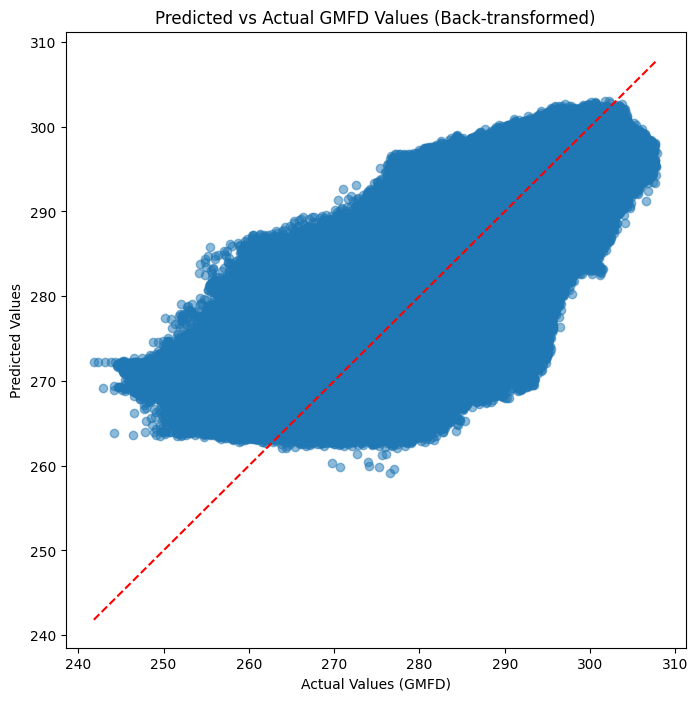

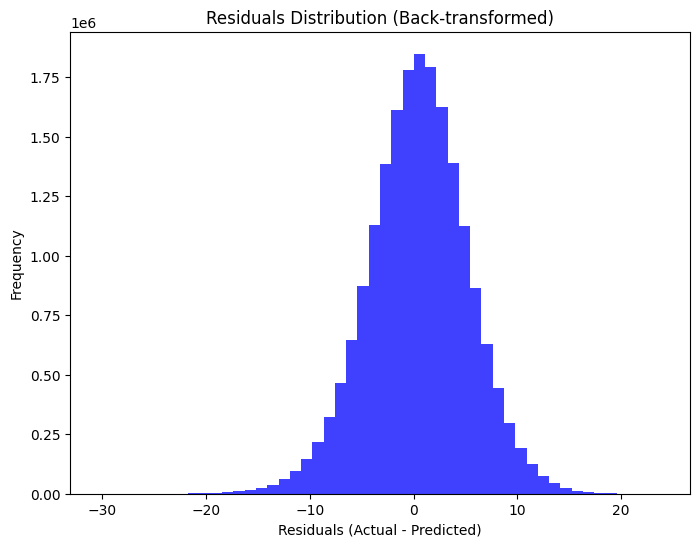

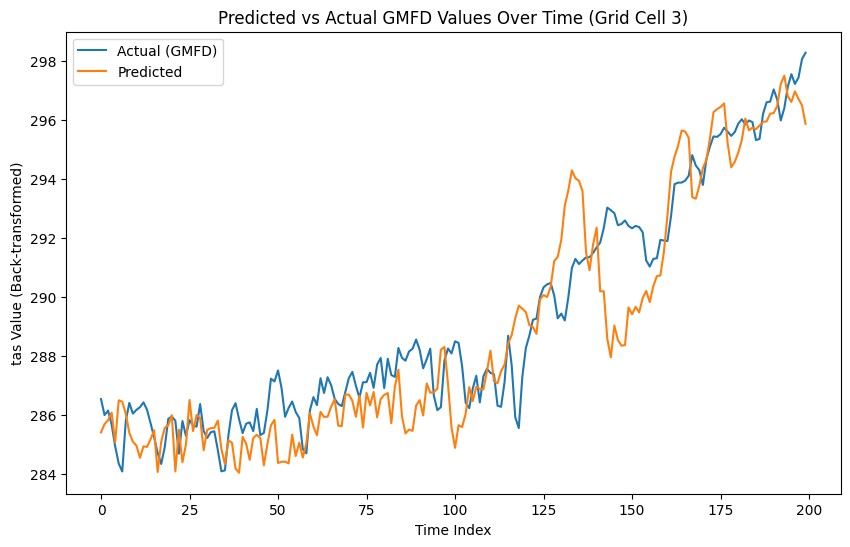

In [14]:
import numpy as np

# Back-transform function
def denormalize(data, mean, std):
    return (data * std) + mean

# Get the mean and std from the training set for denormalization
cmip6_high_res_mean = cmip6_high_res['tas'].mean().values
cmip6_high_res_std = cmip6_high_res['tas'].std().values

# Get the mean and std from the training set for denormalization
gmfd_mean = gmfd_data['tas'].mean().values
gmfd_std = gmfd_data['tas'].std().values

# # Evaluate on the denormalized test data
# val_mse, val_mae = model.evaluate(X_test, y_test, verbose=1)
# print(f"Validation MAE: {val_mae}")
# print(f"Validation MSE: {val_mse}")


# Generate predictions on validation data
y_pred = model.predict(X_val)


# Back-transform the predictions for evaluation
y_val_denorm = denormalize(y_val, cmip6_high_res_mean, cmip6_high_res_std)
y_pred_denorm = denormalize(y_pred, cmip6_high_res_mean, cmip6_high_res_std)

# Plot: Predicted vs Actual Values (back-transformed)
plt.figure(figsize=(8, 8))
plt.scatter(y_val_denorm.flatten(), y_pred_denorm.flatten(), alpha=0.5)
plt.xlabel('Actual Values (GMFD)')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual GMFD Values (Back-transformed)')
plt.plot([y_val_denorm.min(), y_val_denorm.max()], [y_val_denorm.min(), y_val_denorm.max()], 'r--')  # Line of perfect prediction
plt.show()

# Plot: Residuals (Actual - Predicted) after back-transform
residuals_denorm = y_val_denorm.flatten() - y_pred_denorm.flatten()
plt.figure(figsize=(8, 6))
plt.hist(residuals_denorm, bins=50, alpha=0.75, color='blue')
plt.title('Residuals Distribution (Back-transformed)')
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.show()

# Plot: Predicted and Actual Values Over Time for a Specific Grid Cell (Back-transformed)
# Select a grid cell (e.g., the first one)
grid_cell_index = 3
plt.figure(figsize=(10, 6))
plt.plot(y_val_denorm[:200, grid_cell_index, 0].flatten(), label='Actual (GMFD)')
plt.plot(y_pred_denorm[:200, grid_cell_index, 0].flatten(), label='Predicted')
plt.xlabel('Time Index')
plt.ylabel('tas Value (Back-transformed)')
plt.title(f'Predicted vs Actual GMFD Values Over Time (Grid Cell {grid_cell_index})')
plt.legend()
plt.show()


#### Train the Best Model on All Data
Train the model on all the data (no splitting)

In [17]:
input_shape = (cmip6_train.shape[1], cmip6_train.shape[2], 1)  # Assuming 1 channel (tas)
#model = model(input_shape)
# Define early stopping callback
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# Train the model on all the data (no splitting)
history = model.fit(
    cmip6_train_reshaped, gmfd_train_reshaped,
    epochs=1500,
    callbacks=[early_stopping],
    verbose=1
)

# Plot the training loss
plt.plot(history.history['loss'], label='train_loss')
plt.legend()
plt.show()

Epoch 1/1500
742/742 ━━━━━━━━━━━━━━━━━━━━ 68s 92ms/step - loss: 0.2558
Epoch 2/1500
 22/742 ━━━━━━━━━━━━━━━━━━━━ 57s 80ms/step - loss: 0.2549

KeyboardInterrupt: 

 23/742 ━━━━━━━━━━━━━━━━━━━━ 57s 80ms/step - loss: 0.2548

#### Apply the Model to CMIP6 Data to Downscale to GMFD Original Resolution
Now we take the coarse CMIP6 data and downscale it to the original GMFD resolution


In [31]:
# Load the model
from keras.models import load_model
#model = load_model('models/cnn_encoder_decoder.keras')

# Predict downscaled high-resolution data
predicted_high_res = model.predict(cmip6_train_reshaped)

742/742 ━━━━━━━━━━━━━━━━━━━━ 44s 58ms/step


#### Post-process the Predictions

In [32]:
# Inverse transform the predictions to get the actual temperature values


# Get the mean and std from the training set for denormalization
cmip6_high_res_mean = cmip6_high_res['tas'].mean().values
cmip6_high_res_std = cmip6_high_res['tas'].std().values


# Back-transform the predictions and actual values
predicted_high_res_denorm = denormalize(predicted_high_res, cmip6_high_res_mean, cmip6_high_res_std)

# Reshape the predictions to match the original GMFD resolution
predicted_high_res_final = predicted_high_res_denorm.reshape(gmfd_train.shape)

# Save the predictions to a NetCDF file
predicted_ds = xr.DataArray(predicted_high_res_final, dims=gmfd_data.dims, coords=gmfd_data.coords, name='tas_downscaled')
predicted_ds.to_netcdf('/data/keeling/a/ad87/downscale/predicted_high_res_tas_encod.nc')

# #### Results saved to NetCDF format
print("Downscaled high-resolution predictions saved to NetCDF format.")

Downscaled high-resolution predictions saved to NetCDF format.
